<a href="https://colab.research.google.com/github/AhabbscienceStudioPak/PCA-on-Copernicus-Sentinel-Data/blob/main/PCA_on_Copernicus_Sentinel_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PCA on Copernicus Sentinel Data
Developed by Ahabb Sheraz for Linear Algebra Course (ES304) CEP. <br>

Earth observation satellites employ various camera types to capture images of the Earth's land cover. A commonly used camera in this field is the multispectral camera, which captures multispectral images of different Earth locations. Multispectral images share similarities with regular colored images used in our daily lives. However, unlike typical color images that have only three frequencies/spectral bands (Red, Green, and Blue), multispectral images typically consist of a more extensive range of bands, usually between 6 to 30. This increased number of bands allows for improved differentiation between various land cover types (such as crops, forests, water, and land) compared to using only regular colored/RGB images.

Copernicus, administered by the European Union (EU), stands out as one of the world's largest earth observation programs. It utilizes Sentinel satellites to capture Earth images at different wavelengths from space. Similarly, Landsat, a program operated by the US government, serves a comparable purpose.


Attributions: https://medium.com/@mahyar.aboutalebi/downloading-sentinel-2-imagery-in-python-with-google-colab-updated-nov-2023-f21d75a92407

## Install Dependencies

In [ ]:
!pip install pandas rasterio

In [ ]:
import os
import re
import sys
import random
from pathlib import Path

import requests
import json
import xml.etree.ElementTree as ET
import certifi

import pandas as pd
import numpy as np

import rasterio
import matplotlib.pyplot as plt
import matplotlib.image
from rasterio.windows import Window

## Copernicus API Setup

In [ ]:
url_dataspace = "https://catalogue.dataspace.copernicus.eu/odata/v1"

# Filtering
satellite = "SENTINEL-2"
level = "S2MSI2A"
cloud_cover_max = 0.2

aoi_point ="POINT(-120.9970 37.6393)"
aoi_polygon = "POLYGON ((-121.0616 37.6391, -120.966 37.6391, -120.966 37.6987, -121.0616 37.6987, -121.0616 37.6391))"

start_date = "2023-11-01"
end_date = "2023-11-10"
start_date_full =start_date+"T00:00:00.000Z"
end_date_full = end_date +"T00:00:00.000Z"

In [ ]:
query = f"{url_dataspace}/Products?$filter=Collection/Name eq '{satellite}' and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq '{level}') and OData.CSC.Intersects(area=geography'SRID=4326;{aoi_point}') and ContentDate/Start gt {start_date_full} and ContentDate/Start lt {end_date_full}"
response = requests.get(query).json()
result = pd.DataFrame.from_dict(response["value"])

# Filter records where 'online' column is True
#result = result[result['Online'] == True]

# print first 10 results
result.head(10)

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,1c7dcc3f-7c0a-4e26-9f2e-dbf19faff10e,S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_2...,application/octet-stream,514963512,2023-11-03T00:09:45.089Z,2023-11-03T00:28:25.183Z,2023-12-12T19:41:06.766Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/11/02/S2A_MSIL...,"[{'Value': '59a944f68bd6c21bd65956fdeb113124',...","{'Start': '2023-11-02T18:45:31.024Z', 'End': '...",geography'SRID=4326;POLYGON ((-121.26198172100...,"{'type': 'Polygon', 'coordinates': [[[-121.261..."
1,application/octet-stream,8b4c912f-f54d-4b61-bca1-d4cae2e66c07,S2A_MSIL2A_20231105T185551_N0509_R113_T10SFG_2...,application/octet-stream,950862763,2023-11-05T23:15:20.251Z,2023-11-05T23:32:29.458Z,2023-12-13T01:44:19.060Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/11/05/S2A_MSIL...,"[{'Value': '5fba36122824578f253e7385269dcaf0',...","{'Start': '2023-11-05T18:55:51.024Z', 'End': '...",geography'SRID=4326;POLYGON ((-121.86192606806...,"{'type': 'Polygon', 'coordinates': [[[-121.861..."
2,application/octet-stream,821980f4-4d14-4658-8072-e27003f06ea5,S2B_MSIL2A_20231107T184559_N0509_R070_T10SFG_2...,application/octet-stream,538085262,2023-11-07T22:25:05.431Z,2023-11-07T22:43:57.642Z,2023-12-20T18:10:53.204Z,True,,/eodata/Sentinel-2/MSI/L2A/2023/11/07/S2B_MSIL...,"[{'Value': '008c78bb15712ea9da208d0fc28b1056',...","{'Start': '2023-11-07T18:45:59.024Z', 'End': '...",geography'SRID=4326;POLYGON ((-121.27475211534...,"{'type': 'Polygon', 'coordinates': [[[-121.274..."


In [ ]:
username = "<username>"
password = "<password>"


auth_server_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
data = {
    "client_id": "cdse-public",
    "grant_type": "password",
    "username": username,
    "password": password,
}

response = requests.post(auth_server_url, data=data, verify=True, allow_redirects=False)
access_token = json.loads(response.text)["access_token"]

In [ ]:
# Establish session
session = requests.Session()
session.headers["Authorization"] = f"Bearer {access_token}"

## Download the jp2 files

In [ ]:
product_row_id = 0   # 0 for the first product in the list
product_id = result.iloc[product_row_id, 1]
print(product_id)
product_name = result.iloc[product_row_id, 2]
print(product_name)

url_MTD = f"{url_dataspace}/Products({product_id})/Nodes({product_name})/Nodes(MTD_MSIL2A.xml)/$value"
response = session.get(url_MTD, allow_redirects=False)
while response.status_code in (301, 302, 303, 307):
    url_MTD_location = response.headers["Location"]
    response = session.get(url_MTD_location, allow_redirects=False)

file = session.get(url_MTD_location, verify=False, allow_redirects=True)

# Save the product in home directory
outfile = Path("/content/MTD_MSIL2A.xml")
outfile.write_bytes(file.content)

1c7dcc3f-7c0a-4e26-9f2e-dbf19faff10e
S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE


55083

After executing these lines, you should find the metadata file in your folder. In the following lines, we will read the metadata to identify the file path of each Sentinel-2 band. The index line used within “root” is described in this screenshot:

<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*KbJESv9qPu0C8Ku_7VeJRQ.jpeg"/>

The Sentinel-2 satellites carry a Multispectral Imager (MSI) that provides 13 spectral bands with varying pixel sizes, ranging from 10 to 60 meters. This information is valuable for various applications, including land cover mapping, vegetation monitoring, and water resource management.

Here's a breakdown of the Sentinel-2 bands:

| Band | Resolution | Central Wavelength | Description |
|---|---|---|---|
| B1 | 60 m | 443 nm | Ultra Blue (Coastal and Aerosol) |
| B2 | 10 m | 490 nm | Blue |
| B3 | 10 m | 560 nm | Green |
| B4 | 10 m | 665 nm | Red |
| B5 | 20 m | 705 nm | Visible and Near Infrared (VNIR) |
| B6 | 20 m | 740 nm | Visible and Near Infrared (VNIR) |
| B7 | 20 m | 783 nm | Visible and Near Infrared (VNIR) |
| B8 | 10 m | 842 nm | Visible and Near Infrared (VNIR) |
| B8A | 20 m | 865 nm | Visible and Near Infrared (VNIR) |
| B9 | 60 m | 940 nm | Short Wave Infrared (SWIR) |
| B10 | 60 m | 1375 nm | Short Wave Infrared (SWIR) |
| B11 | 20 m | 1610 nm | Short Wave Infrared (SWIR) |
| B12 | 20 m | 2190 nm | Short Wave Infrared (SWIR) |

**Sentinel-2 bands by resolution:**

* **10 meters:** Blue (B2), Green (B3), Red (B4), and Near-infrared (B8)
* **20 meters:** Red edge (B5), Near-infrared NIR (B6, B7, and B8A), and Short-wave infrared SWIR (B11 and B12)
* **60 meters:** Coastal aerosol (B1) and cirrus band (B10)

**Applications of Sentinel-2 bands:**

* **B1 and B10:** Coastal water quality monitoring, aerosol detection
* **B2-B4:** Land cover mapping, vegetation monitoring, urban planning
* **B5-B8A:** Vegetation health assessment, water resource management
* **B9-B12:** Mineral exploration, soil moisture mapping

By understanding the characteristics and applications of each band, we can effectively leverage Sentinel-2 data for various Earth observation tasks.


In [ ]:
# Pass the path of the xml document
tree = ET.parse(str(outfile))
# get the parent tag
root = tree.getroot()

# Get the location of individual bands in Sentinel-2 granule
band_path = []
band_path.append(f"{product_name}/{root[0][0][12][0][0][0].text}.jp2".split("/"))
band_path.append(f"{product_name}/{root[0][0][12][0][0][1].text}.jp2".split("/"))
band_path.append(f"{product_name}/{root[0][0][12][0][0][2].text}.jp2".split("/"))
band_path.append(f"{product_name}/{root[0][0][12][0][0][3].text}.jp2".split("/"))

In [ ]:
band_path

[['S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE',
  'GRANULE',
  'L2A_T10SFG_A043682_20231102T184854',
  'IMG_DATA',
  'R10m',
  'T10SFG_20231102T184531_B02_10m.jp2'],
 ['S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE',
  'GRANULE',
  'L2A_T10SFG_A043682_20231102T184854',
  'IMG_DATA',
  'R10m',
  'T10SFG_20231102T184531_B03_10m.jp2'],
 ['S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE',
  'GRANULE',
  'L2A_T10SFG_A043682_20231102T184854',
  'IMG_DATA',
  'R10m',
  'T10SFG_20231102T184531_B04_10m.jp2'],
 ['S2A_MSIL2A_20231102T184531_N0509_R070_T10SFG_20231102T231756.SAFE',
  'GRANULE',
  'L2A_T10SFG_A043682_20231102T184854',
  'IMG_DATA',
  'R10m',
  'T10SFG_20231102T184531_B08_10m.jp2']]

Download the bands

In [ ]:
# Build the url
for band_node in band_path:
    url_full = f"{url_dataspace}/Products({product_id})/Nodes({product_name})/Nodes({band_node[1]})/Nodes({band_node[2]})/Nodes({band_node[3]})/Nodes({band_node[4]})/Nodes({band_node[5]})/$value"
    #print(url_full)
    response = session.get(url_full, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url_full_location = response.headers["Location"]
        response = session.get(url_full_location, allow_redirects=False)
    file = session.get(url_full_location, verify=False, allow_redirects=True)
    # Save the product
    outfile =Path("/content/"+band_node[5])
    outfile.write_bytes(file.content)
    print("Saved:", band_node[5])

Saved: T10SFG_20231102T184531_B02_10m.jp2
Saved: T10SFG_20231102T184531_B03_10m.jp2
Saved: T10SFG_20231102T184531_B04_10m.jp2
Saved: T10SFG_20231102T184531_B08_10m.jp2


In [ ]:
bands = [
"T10SFG_20231102T184531_B02_10m.jp2",
"T10SFG_20231102T184531_B03_10m.jp2",
"T10SFG_20231102T184531_B04_10m.jp2",
]

In [ ]:
data = []
for band in bands:
    with rasterio.open(band) as src:
        data.append(src.read(1))

data = np.stack(data, axis=-1)

## Standardize Data

In [ ]:
mean = np.mean(data, axis=(0, 1))
centered_data = data - mean
standardized_data = centered_data / np.std(centered_data, axis=(0, 1))

In [ ]:
# Print shape of the data array after standardization
print("Standardized data shape:", standardized_data.shape)

Standardized data shape: (10980, 10980, 3)


## Calculate Covariance Matrix
Covariance: $\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{N}(x_{ij}-\bar{x_j})(x_{ik}-\bar{x_k})$

Coviance matrix = $\frac{1}{n-1}((X-\bar{x})^T(X-\bar{x}))$

In [ ]:
covariance_matrix = np.cov(standardized_data.reshape(-1, standardized_data.shape[-1]).T)

print("Covariance Matrix: \n",covariance_matrix)

Covariance Matrix: 
 [[1.00000001 0.9972695  0.98380118]
 [0.9972695  1.00000001 0.99144208]
 [0.98380118 0.99144208 1.00000001]]


## Perform PCA

Compute the Eigenvectors and Eigenvalues
Eigendecomposition of the covriance matrix =  $PDP^{-1}$

In [ ]:
# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Select desired number of principal components
n_components = 2

# Select top n_components eigenvectors
principal_components = eigenvectors[:, :n_components]

# Project data onto principal components
projected_data = standardized_data @ principal_components

# Calculate explained variance ratio
explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)

# Print results
print("Original data shape:", data.shape)
print("Standardized data shape:", standardized_data.shape)
print("Eigenvalues:", eigenvalues)
print("Explained variance ratio:", explained_variance_ratio)
print("Projected data shape:", projected_data.shape)

Original data shape: (10980, 10980, 3)
Standardized data shape: (10980, 10980, 3)
Eigenvalues: [2.98168541e+00 1.69578774e-02 1.35673702e-03]
Explained variance ratio: [0.99389513 0.00565263]
Projected data shape: (10980, 10980, 2)


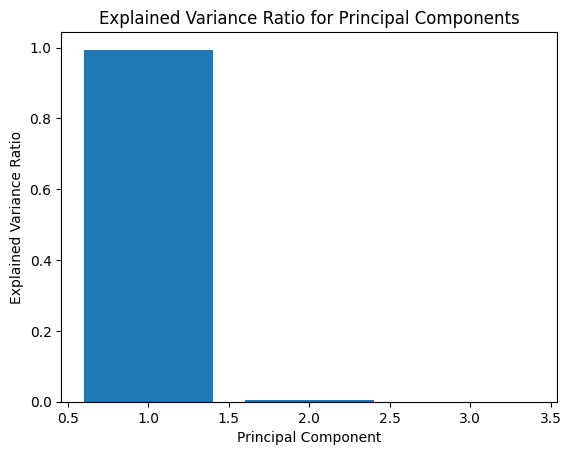

In [ ]:
# Calculate explained variance ratio
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

# Plot the bar graph
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Principal Components')
plt.show()

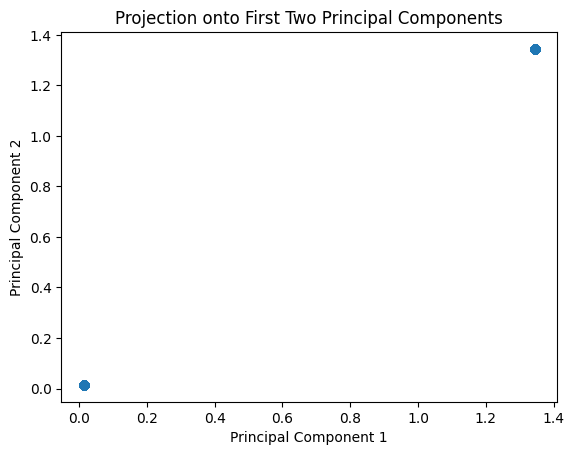

In [ ]:
# Visualize scatter plot of the first two principal components
plt.scatter(projected_data[:, 0], projected_data[:, 1])
plt.title("Projection onto First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()